In [ ]:
import numpy as np
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
# Select which GPUs to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [51]:
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN, LSTM
from trainer import Trainer
# TqdmExperimentalWarning warning results from progress bar

In [66]:
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = 'models'
options.n_epochs = 5          # number of training epochs
options.n_steps = 1000        # batches per epoch
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

options.run_ID = generate_run_ID(options)

In [67]:
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
model = RNN(options, place_cells)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

# Load example weights stored on github
weight_dir = options.save_dir + '/example_trained_weights.npy'
load_trained_weights(model, trainer, weight_dir)

Initializing new model from scratch.



Loaded trained weights.


# Task statistics

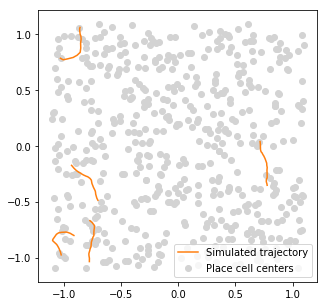

In [54]:
# Plot a few sample trajectories
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
us = place_cells.us

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')
for i in range(5):
    plt.plot(pos[i,:,0],pos[i,:,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

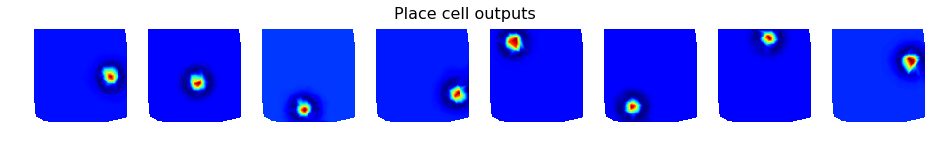

In [55]:
# Plot a few place cell outputs
pc_outputs = tf.reshape(pc_outputs, (-1, options.Np))
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# plt.tight_layout()

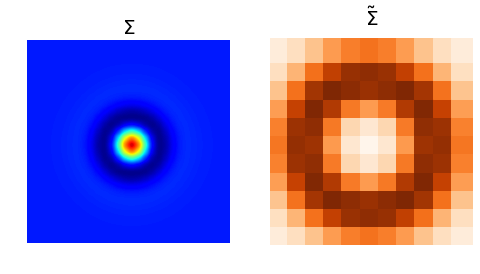

In [56]:
# Visualize place cell covariance matrix
Cmean = place_cells.compute_covariance(res=30)

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)
width = 6
idxs = np.arange(-width+1, width)
x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))
plt.scatter(x2,y2,c=np.abs(Ctilde)[idxs][:,idxs], s=600, cmap='Oranges', marker='s')

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

# Train model

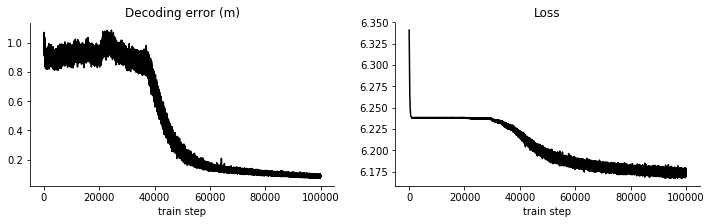

In [59]:
trainer.train(n_epochs=100, n_steps=1000, save=True)

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(trainer.err, c='black')

plt.title('Decoding error (m)'); plt.xlabel('train step')
sns.despine()
plt.subplot(122)
plt.plot(trainer.loss, c='black');
plt.title('Loss'); plt.xlabel('train step')
sns.despine()

## Evaluate performance

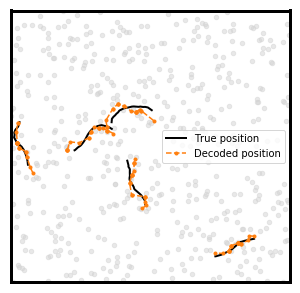

In [57]:
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
true_pos = place_cells.get_nearest_cell_pos(pc_outputs)
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[i,:,0], pos[i,:,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[i,:,0], pred_pos[i,:,1], '.-',
             c='C1', linestyle='dashed', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(place_cells.us[:,0], place_cells.us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);
# plt.savefig('images/sim_traj_decode.pdf')

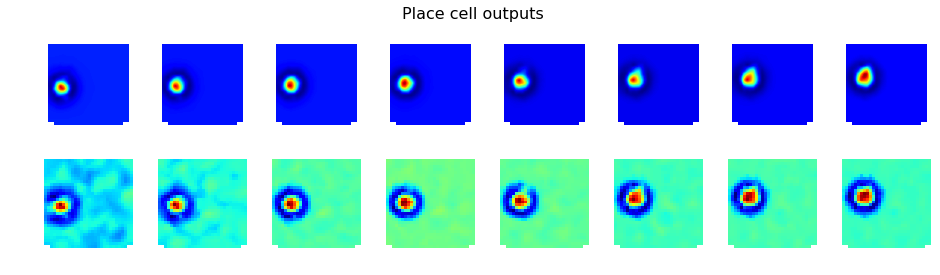

In [74]:
# Visualize predicted place cell outputs
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
preds = model.predict(inputs)
preds = tf.reshape(preds, (-1, options.Np))
pc_outputs = tf.reshape(tf.nn.softmax(pc_outputs, axis=-1), (-1, options.Np))
pc_pred = place_cells.grid_pc(preds[:100])
pc = place_cells.grid_pc(pc_outputs[:100])

plt.figure(figsize=(16,4))
for i in range(8):
    plt.subplot(2,8,i+9)
    plt.imshow(pc_pred[2*i], cmap='jet')
    if i==0:
        plt.ylabel('Predicted')
    plt.axis('off')
    
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(pc[2*i], cmap='jet', interpolation='gaussian')
    if i==0:
        plt.ylabel('True')
    plt.axis('off')
    
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

# Ratemaps

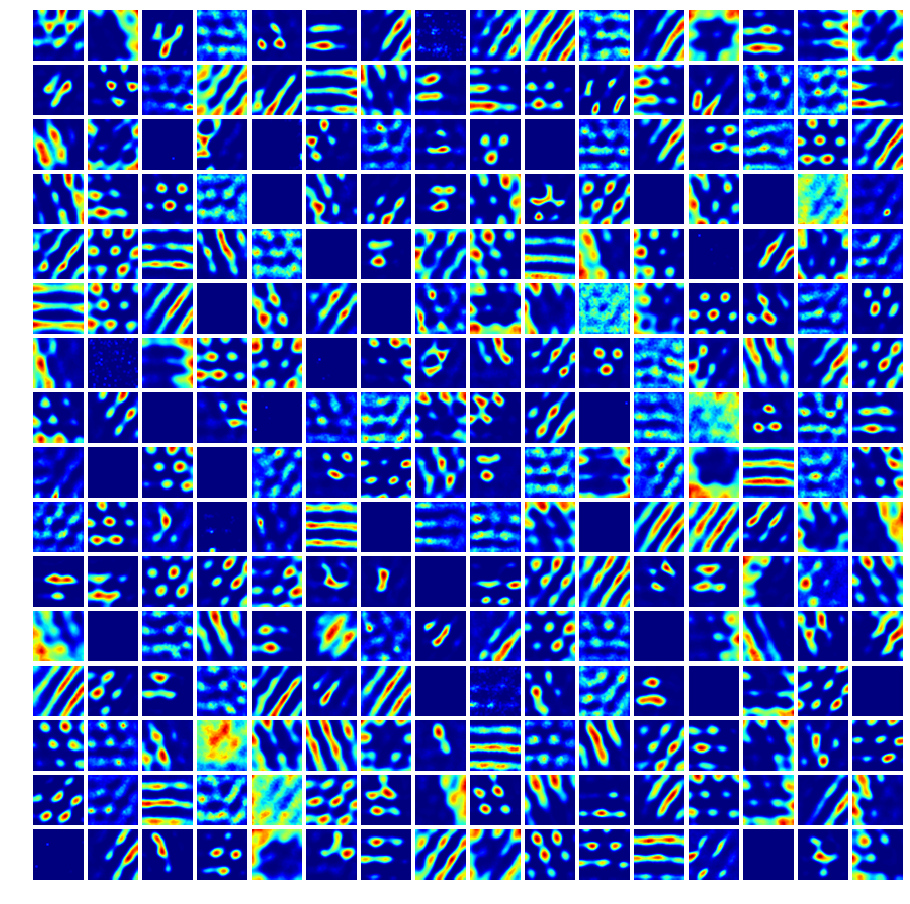

In [75]:
from visualize import compute_ratemaps, plot_ratemaps
res = 50
n_avg = 100
Ng = options.Ng
activations, rate_map, g, pos = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng)
n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');